<a href="https://colab.research.google.com/github/sergiobm3/ESI_MachineLearning/blob/Supervised/Dengue_KNN_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  The Problem


We will use the data from the competition to predict the evolution of Dengue Disease in both Iquitos and San Juan. More information in [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

The objective of the exercise is to solve a regression problem and on the other hand to participate in a data competition.


# Setting Preliminares

Before starting any analysis we must ensure that the basic and general use libraries (numpy, pandas, etc.) are correctly imported. 

In [2]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

# Data Loading

First we load the data into the environment with the functionalities provided by Google Colab

In [3]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

1. We upload training data without a target attribute (dengue_features_train)


In [22]:
train_feat = upload_files()
train_feat

Saving dengue_features_train.csv to dengue_features_train (2).csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [23]:
train_feat.shape

(1456, 24)

2. We upload the data that only provide us with the number of dengue cases during the training weeks (dengue_labels_train)

In [24]:
train_labels = upload_files()
train_labels

Saving dengue_labels_train.csv to dengue_labels_train (2).csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


3. We merge the two sets of data to have them in a single dataframe

In [25]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])

train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


4.  Finally we upload the data to generate the submission data (dengue_features_test)


In [26]:
test = upload_files()
test

Saving dengue_features_test.csv to dengue_features_test (2).csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1


# Preprocessing

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, ...

In [27]:
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)
train.head()


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


It is necessary to address the missing values to improve the quality of the data that will be used to generate the models. 

In [28]:
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_t

We will process them automatically by completing them with the ffill method (with the previous value)

In [29]:
# ffill: propagate last valid observation forward to next valid backfill
# Otra Opción: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
#train.fillna(method='ffill', inplace=True)   #lo hacemos con ffill o con df.fillna(df.mean())
train.fillna(train.mean(),inplace=True)
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

And we apply the same for the test (**IMPORTANT!!!**)

In [30]:
#test.fillna(method='ffill', inplace=True)
test.fillna(test.mean(),inplace=True)
pd.isnull(test).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

We also have to transform our categorical variables, in this case a single variable that is the city for which we will use a *binarizer* for train and for test

In [31]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

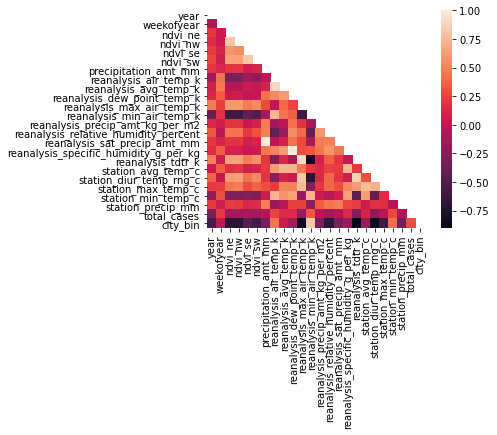

In [32]:
import seaborn as sns

mask = np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True

#sns.set()
sns.heatmap(train.corr(),xticklabels=train.corr().columns,yticklabels=train.corr().columns, mask= mask,square=True, annot=False)

You have to select features, they can be all, but that is usually not a good idea, so here we will leave some selected.

In [34]:
selecting_features = train.copy()
selecting_features

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_bin
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,1
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,1
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,1
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5,0
1452,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8,0
1453,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1,0
1454,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1,0


We should delete some features before selecting the best features

In [36]:
selecting_features.drop(labels=['city','city_bin','year','reanalysis_sat_precip_amt_mm'],axis=1,inplace=True)

Select the best features.

In [39]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression,k=4).fit(selecting_features,train['total_cases']) #substitute train by selecting_features
cols = selector.get_support(indices=True)

cols = np.append(cols,train.columns.get_loc('total_cases'))

In [ ]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c', 'total_cases']

In [40]:
X = train.iloc[:,cols]
#X = train[selected_features]
y = train['total_cases']

In [41]:
print("Selected features: ")
X.columns

Selected features: 


Index(['reanalysis_dew_point_temp_k', 'reanalysis_relative_humidity_percent',
       'station_avg_temp_c', 'station_max_temp_c', 'total_cases'],
      dtype='object')

In [42]:
X

,reanalysis_dew_point_temp_k,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,total_cases
0,292.414286,73.365714,25.442857,29.4,4
1,293.951429,77.368571,26.714286,31.7,5
2,295.434286,82.052857,26.714286,32.2,4
3,295.310000,80.337143,27.471429,33.3,3
4,295.821429,80.460000,28.942857,35.0,6
...,...,...,...,...,...
1451,296.825714,88.765714,28.633333,35.4,5
1452,296.452857,91.600000,27.433333,34.7,8
1453,295.501429,94.280000,24.400000,32.2,1
1454,295.324286,94.660000,25.433333,31.2,1


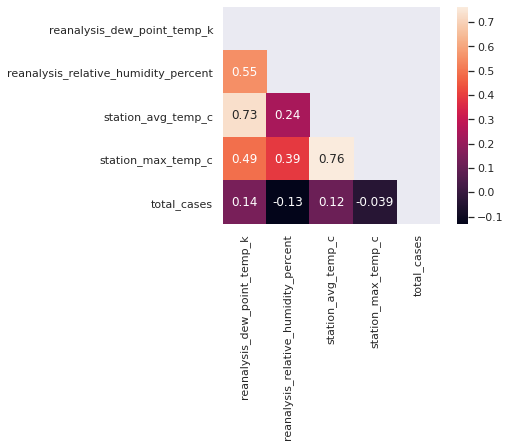

In [43]:
import seaborn as sns

mask = np.zeros_like(X.corr())
mask[np.triu_indices_from(mask)] = True

sns.set()
sns.heatmap(X.corr(), mask=mask, square=True, annot=True)

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(train[selected_features])
#X_test = scaler.transform(test[selected_features])
#y_train = train['total_cases']

In [44]:
from sklearn.model_selection import train_test_split

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Modelling

**CROSS - VALIDATION**: The data are split into train and test sets several consecutive times and the averaged value of the prediction scores obtained with the different sets is the estimation of the error [link]([https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada)

[MAE](https://es.wikipedia.org/wiki/Valor_absoluto) as error metric

In [45]:
# rest index avoid problems in cross validation
X_train.reset_index(drop = True, inplace = True)
X_train.head()

,reanalysis_dew_point_temp_k,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,total_cases
0,295.557143,83.628571,26.328571,28.9,15
1,296.687143,80.270000,27.942857,31.1,71
2,295.491429,78.292857,28.328571,32.8,31
3,295.252857,82.648571,26.628571,31.1,60
4,296.322857,80.245714,28.657143,32.8,14


Min Value uniform : 21.709527302199717 (22)
Min Value distance : 21.686658847009937 (24)


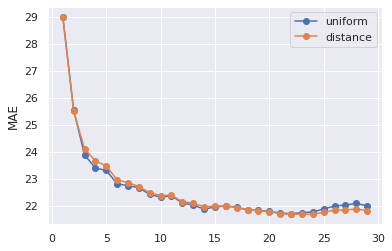

In [46]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          f_train = X_train.loc[train_fold]
          f_test = X_train.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                               y = f_train['total_cases'])
          y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['total_cases'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 


# Submission result

We generate the output file according to the Submission format

Once we have identified the best parameterization we will go on to make an execution of the model and we will graph its results.


In [47]:
# constructor
n_neighbors = 22
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train.drop(['total_cases'], axis=1), y = y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=22, p=2,
                    weights='uniform')

1. We carry out the prediction on the test.

In [48]:
y_pred = knn.predict(X = X_test.drop(['total_cases'], axis = 1))
mae = mean_absolute_error(X_test['total_cases'], y_pred)
print ('MAE', mae)

MAE 19.74299501867995


Finally we try to visualize how our prediction has turned out with reality.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


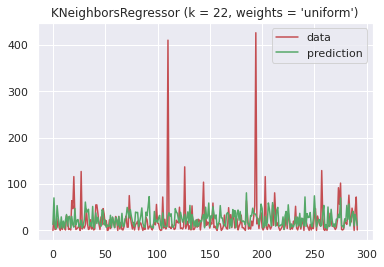

In [49]:
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(X_test['total_cases'].shape[0]))
plt.plot(xx, X_test['total_cases'], c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

2. We round up the result. **We use dataset TEST!**

In [54]:
X_test

,reanalysis_dew_point_temp_k,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,total_cases
1106,296.312857,92.165714,27.200000,35.7,0
111,296.042857,84.248571,28.285714,32.8,26
1271,297.608571,96.795714,28.400000,33.7,2
1145,294.814286,90.905714,26.550000,32.0,3
368,295.262857,78.711429,27.314286,31.7,7
...,...,...,...,...,...
280,297.051429,82.911429,29.371429,35.0,33
1398,296.012857,91.790000,28.350000,34.6,0
131,296.270000,81.052857,28.385714,33.3,44
898,296.915714,77.765714,28.614286,31.7,72


In [57]:
X_test

,reanalysis_dew_point_temp_k,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,total_cases
1106,296.312857,92.165714,27.200000,35.7,0
111,296.042857,84.248571,28.285714,32.8,26
1271,297.608571,96.795714,28.400000,33.7,2
1145,294.814286,90.905714,26.550000,32.0,3
368,295.262857,78.711429,27.314286,31.7,7
...,...,...,...,...,...
280,297.051429,82.911429,29.371429,35.0,33
1398,296.012857,91.790000,28.350000,34.6,0
131,296.270000,81.052857,28.385714,33.3,44
898,296.915714,77.765714,28.614286,31.7,72


In [58]:
#y_pred = knn.predict(X = test[['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k','station_avg_temp_c', 'station_min_temp_c']])
#y_pred = knn.predict(X = test[['year', 'reanalysis_min_air_temp_k','reanalysis_tdtr_k', 'city_bin']])
y_pred = knn.predict(X = test[['reanalysis_dew_point_temp_k','reanalysis_relative_humidity_percent','station_avg_temp_c','station_max_temp_c']])

In [59]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([25, 25, 46, 24, 23, 33, 18, 49, 44, 36, 17, 26, 34, 42, 50, 52, 49,
       42, 34, 41, 58, 32, 49, 36, 49, 26, 25, 26, 24, 33, 12, 24, 15, 18,
       14, 33, 13, 26, 24, 33, 25, 17, 18, 18, 14, 17, 21, 16, 20, 14, 17,
       22, 29, 14, 28, 33, 43, 33, 60, 47, 38, 44, 38, 46, 42, 51, 39, 38,
       51, 43, 57, 52, 79, 69, 58, 51, 46, 53, 51, 38, 21, 63, 34, 17, 21,
       26, 29, 33, 43, 35, 38, 43, 17, 16, 21, 30, 37, 18, 16, 32, 31,  9,
       13, 36, 57, 61, 38, 30, 48, 63, 39, 33, 47, 60, 57, 40, 70, 58, 52,
       39, 48, 38, 32, 37, 46, 45, 28, 57, 45, 41, 45, 38, 36, 30, 22, 22,
       22, 41, 19, 13, 22, 30, 22, 26, 14, 17, 24, 26, 24, 15, 22, 11, 26,
       26, 17, 25, 19, 35, 14, 53, 36, 39, 35, 35, 54, 42, 70, 54, 31, 72,
       41, 68, 30, 63, 33, 42, 44, 24, 49, 31, 38, 38, 22, 27, 49, 20, 41,
       39, 17, 41, 21, 19, 20, 27, 14, 25, 22, 25, 19, 26, 12, 18, 20, 16,
       29, 19, 31, 14, 22, 41, 36, 66, 60, 28, 72, 51, 79, 61, 66, 37, 34,
       44, 47, 44, 40, 45

3. We build the output file


In [60]:
# generate output
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')
output.head()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,25
1,sj,2008,19,25
2,sj,2008,20,46
3,sj,2008,21,24
4,sj,2008,22,23


Upload new submission
Woohoo! We processed your submission!
Your score for this submission is:

28.6779 (With the selected features in the array)
Woo! I scored 28.6779 on 'DengAI: Predicting Disease Spread'!

28.6851 (With the selectKbest)